# Assignment — Generative Network Models

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from zlib import adler32
import requests
import networkx as nx
from scipy.stats import ks_2samp
import random
from sklearn.preprocessing import minmax_scale

### Task 1. Erdos Renyi model (0.75 point)

Implement Erdos Renyi model (random graph) — each pair of $n$ nodes are connected with some fixed probability $p$.

In [2]:
'''Do not touch this cell'''
def erdos_renyi_graph(n, p):
    G = nx.Graph()
    nodes = np.arange(n)
    G.add_nodes_from(nodes)
    G.add_edges_from(random_edges(nodes, p))
    return G

Write a function `random_edges` with parameters: `nodes` — np.array of nodes, for example [1, 2, 3, 4, ...] and `p` — probability of connection. The function returns np.array with tuples of the form [(1, 2), (2, 4), ...], where 1-2, 2-4 are edges that should be added in the graph.

*Hint: To speed up the generation, look at ALG.1 in the article [Efficient generation of large random networks](http://vlado.fmf.uni-lj.si/pub/networks/doc/ms/rndgen.pdf).*

In [3]:
import itertools as it

def random_edges(nodes, p):
    # YOUR CODE HERE
    # raise NotImplementedError()
    new_edges = []
    for edge in it.combinations(nodes, 2):
        if random.random() < p:
            new_edges.append(edge)
            
    return np.array(new_edges)

In [4]:
'''Check the Erdos-Renyi random graph generation'''
assert len(erdos_renyi_graph(100, 0.1).edges) > 0
n = 100
p = 0.4
n_edges = n * (n-1) / 2
q = 1 - p
sigma = np.sqrt((p * q) / n_edges)
assert  p - 3*sigma < random_edges(np.arange(n), p).shape[0] / n_edges < p + 3*sigma
n = 1000
p = 0.01
n_edges = n * (n-1) / 2
q = 1 - p
sigma = np.sqrt((p * q) / n_edges)
assert  p - 3*sigma < random_edges(np.arange(n), p).shape[0] / n_edges < p + 3*sigma
n = 300
p = 0.9
n_edges = n * (n-1) / 2
q = 1 - p
sigma = np.sqrt((p * q) / n_edges)
assert  p - 3*sigma < random_edges(np.arange(n), p).shape[0] / n_edges < p + 3*sigma

Let us draw a couple of generated graphs

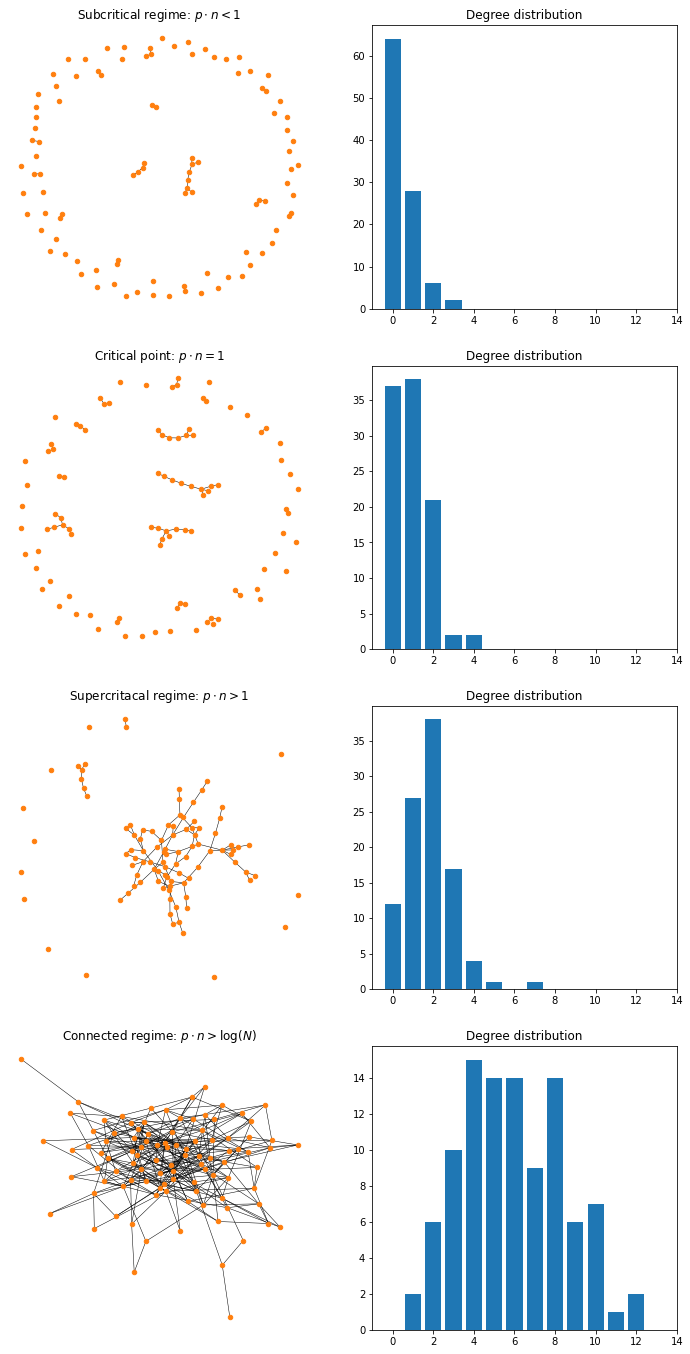

In [5]:
n = 100
cases = [('Subcritical regime: $p \cdot n < 1$', n, 0.5/n), 
         ('Critical point: $p \cdot n = 1$', n, 1/n), 
         ('Supercritacal regime: $p \cdot n > 1$', n, 2/n), 
         ('Connected regime: $p \cdot n > \log(N)$', n, 6.5/n)]
plt.figure(figsize=(12, 6 * 4))
i = 1
for regime, n, p in cases:
    plt.subplot(4, 2, i)
    G = erdos_renyi_graph(n, p)
    nx.draw(
        G, 
        with_labels=False, 
        node_size=20, 
        width=0.5, 
        node_color='tab:orange')
    plt.title(regime)
    i += 1
    plt.subplot(4, 2, i)
    degree_seq = [degree for (node, degree) in G.degree]
    bins, freq = np.unique(degree_seq, return_counts=True)
    plt.bar(bins, freq)
    plt.xlim((-1, 14))
    plt.title('Degree distribution')
    i += 1

### Task 2. Degree distribution of random vs real networks (0.75 point)

In [6]:
url = 'https://raw.githubusercontent.com/netspractice/ml-on-graphs/main/datasets/wiki_vote.txt'
open('wiki_vote.txt', 'wb').write(requests.get(url).content)

url = 'https://raw.githubusercontent.com/netspractice/ml-on-graphs/main/datasets/facebook_combined.txt'
open('facebook_combined.txt', 'wb').write(requests.get(url).content)

url = 'https://raw.githubusercontent.com/netspractice/ml-on-graphs/main/datasets/collaboration_network_of_arxiv_general_relativity_category.txt'
open('collaboration_network_of_arxiv_general_relativity_category.txt', 'wb').write(requests.get(url).content);


Let us compare degree distributions of real and random networks and decide whether they are close or not.

Write a function `random_from_real` that takes a graph and returns a random network that has the same average node degree and the same number of nodes as a given network. 

In [7]:
def random_from_real(graph):
    # YOUR CODE HERE
    # raise NotImplementedError()
    
    degree_dict = graph.degree
    degrees = []
    
    for node_name in graph.nodes:
        degrees.append(graph.degree[node_name])
        
    avg_degree = np.mean(degrees)
    p = avg_degree / len(graph)
    
    return nx.erdos_renyi_graph(len(graph), p) 

In [8]:
for file in ['wiki_vote.txt', 
             'collaboration_network_of_arxiv_general_relativity_category.txt', 
             'facebook_combined.txt']:
    real_net = nx.read_edgelist(file)
    random_net = random_from_real(real_net)
    av_degree_random = np.mean(list(dict(random_net.degree).values()))
    av_degree_real = np.mean(list(dict(real_net.degree).values()))
    assert len(random_net) == len(real_net)
    assert np.abs(av_degree_random - av_degree_real) < 1

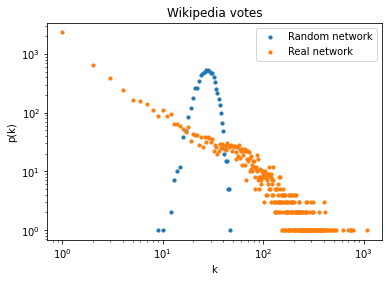

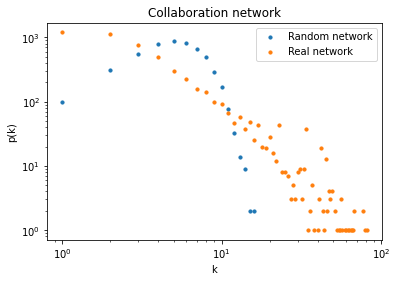

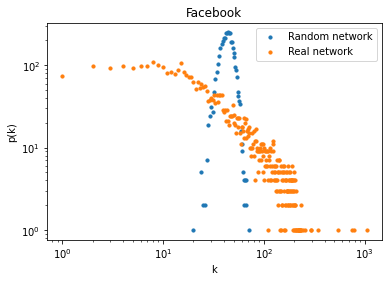

In [9]:
cases = [['Wikipedia votes', 'wiki_vote.txt'], 
         ['Collaboration network', 'collaboration_network_of_arxiv_general_relativity_category.txt'], 
         ['Facebook', 'facebook_combined.txt']]
for title, file in cases:
    real_net = nx.read_edgelist(file)
    random_net = random_from_real(real_net)
    degree_hist = np.array(nx.degree_histogram(random_net))
    idx = np.argwhere(degree_hist > 0)
    plt.scatter(idx, degree_hist[idx], s=10, label='Random network')
    degree_hist = np.array(nx.degree_histogram(real_net))
    idx = np.argwhere(degree_hist > 0)
    plt.scatter(idx, degree_hist[idx], s=10, label='Real network')
    plt.legend()
    plt.xlabel('k')
    plt.ylabel('p(k)')
    plt.title(title)
    plt.xscale('log')
    plt.yscale('log')
    plt.show()

### Task 3. Component sizes (1.4 points)

Let us see how the size of small components (small — not giant) depends on the probability near the critical point: $p =1/n$.

Write a function `small_component_size` with parameters `n` — number of nodes, `probabilities` — np.array of probabilities. The function generates a random graph for each probability and returns np.array of average sizes of small components.

*Hint: to find nodes in components, use `nx.connected_components(graph)`*

In [10]:
def small_component_size(n, probabilities):
    # YOUR CODE HERE
    # raise NotImplementedError()
    
    result = []
    for p in probabilities:
        graph = nx.fast_gnp_random_graph(n, p)
        
        components = []
        for c in nx.connected_components(graph):
            if len(c) < 1 / p:
                components.append(len(c))
        result.append(np.array(components).mean())
    
    return np.array(result)

In [11]:
n = 1000
p_space = np.linspace(0.01/n, 2.5/n, 50)
sizes = []
for _ in range(5):
    size = small_component_size(n, p_space)
    assert size.shape == (50,)
    sizes.append(size)

av_sizes = np.mean(sizes, axis=0)
assert av_sizes[0] < av_sizes[np.argmin(np.abs(p_space*n - 1))]
assert av_sizes[49] < av_sizes[np.argmin(np.abs(p_space*n - 1))]

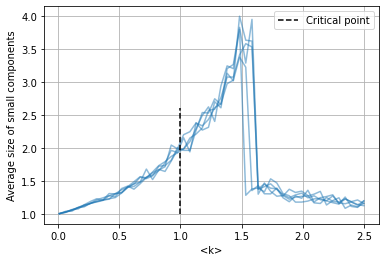

In [12]:
for i in range(5):
    plt.plot(p_space*n, sizes[i], c='tab:blue', alpha=0.5)
plt.plot([1, 1], [1, 2.6], 'k--', label='Critical point')
plt.xlabel('<k>')
plt.ylabel('Average size of small components')
plt.legend()
plt.grid()
plt.show()

Also let us see how the size of a giant component depends on the probability near the critical point.

Write a function `giant_component_size` with parameters `n` — number of nodes, `probabilities` — np.array of probabilities. The function generates a random graph for each probability and returns np.array of sizes of a giant component.

*Hint: to find nodes in a ginat component, use `max(nx.connected_components(graph), key=len)`*

In [13]:
def giant_component_size(n, probabilities):
    # YOUR CODE HERE
    # raise NotImplementedError()
    
    result = []
    for p in probabilities:
        graph = nx.fast_gnp_random_graph(n, p)
        result.append(len(max(nx.connected_components(graph), key=len)))
    
    return np.array(result)

In [14]:
n = 1000
p_space = np.linspace(0.01/n, 2.5/n, 50)
sizes = []
for _ in range(5):
    size = giant_component_size(n, p_space)
    assert size.shape == (50,)
    sizes.append(size)

av_sizes = np.mean(sizes, axis=0)
assert av_sizes[0] < 20
assert 20 < av_sizes[np.argmin(np.abs(p_space*n - 1))] < 150
assert 700 < av_sizes[np.argmin(np.abs(p_space*n - 2))] < 900

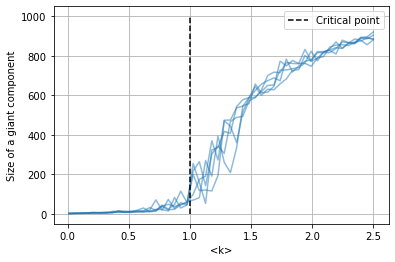

In [15]:
for i in range(5):
    plt.plot(p_space*n, sizes[i], c='tab:blue', alpha=0.5)
plt.plot([1, 1], [0, 1000], 'k--', label='Critical point')
plt.xlabel('<k>')
plt.ylabel('Size of a giant component')
plt.legend()
plt.grid()
plt.show()

### Task 4. Clustering coefficients of random vs real networks (1.4 points)

Clustering coefficient of a node $C_i$ contains information about relationship between nearest neighbors.  $C_i = 0$ means that there is no links between neighbors and $C_i = 1$ means that there are all possible links between them. Clustering coefficient of an Erdos-Renyi random graph is equal to the probability $p$ and does not dependent of a node and its degree:

$$C_i = \langle C \rangle = \frac{\langle k \rangle}{n} = p $$

Let us check it on generated data.

Write a function `node_degree_clustering` with parameters `n, p` — number of nodes and probability. The function generates Erdos-Renyi random graph and returns a tuple with two np.arrays: degrees and clustering coefficients. Ordering of elements should coincide: the first degree and first clustering coefficient are related to the first node and so on.

*Hint: to calculate clustering coefficients, use `nx.clustering(graph)`*

In [16]:
def node_degree_clustering(n, p):
    # YOUR CODE HERE
    # raise NotImplementedError()
    
    graph = nx.erdos_renyi_graph(n, p)
    
    degree = []
    clustering = []
    
    coefficients = nx.clustering(graph)
    for key in coefficients:
        degree.append(key)
        clustering.append(coefficients[key])    
        
    return np.array(degree), np.array(clustering)

In [17]:
p = 0.9
n = 100
degree, clustering = node_degree_clustering(n, p)
assert degree.shape == clustering.shape
assert clustering.mean() - 3*clustering.std() < p < clustering.mean() + 3*clustering.std()
assert degree.mean() - 3*degree.std() < p * n < degree.mean() + 3*degree.std()
p = 0.1
n = 1000
degree, clustering = node_degree_clustering(n, p)
assert degree.shape == clustering.shape
assert clustering.mean() - 3*clustering.std() < p < clustering.mean() + 3*clustering.std()
assert degree.mean() - 3*degree.std() < p * n < degree.mean() + 3*degree.std()
p = 0.01
n = 3000
degree, clustering = node_degree_clustering(n, p)
assert degree.shape == clustering.shape
assert clustering.mean() - 3*clustering.std() < p < clustering.mean() + 3*clustering.std()
assert degree.mean() - 3*degree.std() < p * n < degree.mean() + 3*degree.std()

Let us draw the dependency between node degree and clustering coefficient

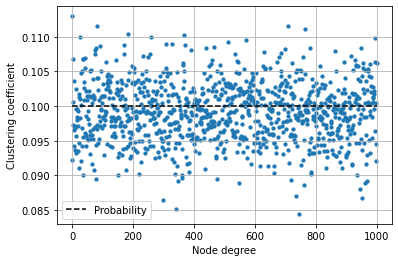

In [18]:
p = 0.1
n = 1000
degree, clustering = node_degree_clustering(n, p)
plt.scatter(degree, clustering, s=15, linewidths=0.3)
plt.plot([degree.min(), degree.max()], [p, p], 'k--', label='Probability')
plt.xlabel('Node degree')
plt.ylabel('Clustering coefficient')
plt.legend()
plt.grid()
plt.show()

Let us look at the dependency of a some real social network.

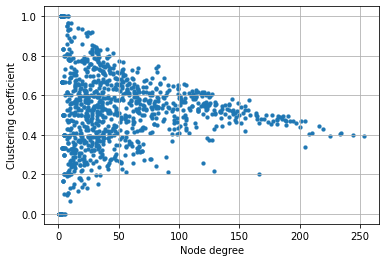

In [19]:
degree = np.loadtxt(
    'https://raw.githubusercontent.com/netspractice/ml-on-graphs/main/datasets/real_net_degree.txt'
)
clustering = np.loadtxt(
    'https://raw.githubusercontent.com/netspractice/ml-on-graphs/main/datasets/real_net_clustering.txt'
)
plt.scatter(degree, clustering, s=15, linewidths=0.3)
plt.xlabel('Node degree')
plt.ylabel('Clustering coefficient')
plt.grid()
plt.show()

We can see that the average clustering coefficient slightly decreases in high degrees.

### Task 5. Snobbish Networks (1.4 points)

Consider a network of $N$ red and $N$ blue nodes. The probability that there is a link between nodes of identical color is $p$ and the probability that there is a link between nodes of different color is $q$. A network is snobbish if $p>q$, capturing a tendency to connect to nodes of the same color. For $q = 0$ the network has at least two components, containing nodes with the same color.

Write a function `snobbish_network` that takes the number of red (or blue) nodes `n`, probability of link between nodes of the same color `p` and probability of link between nodes of different color `q`. The function returns a network with $2N$ nodes where every node has an attribute `color` that can be `blue` or `red`.

*Hint: to set node attributes, use `nx.set_node_attributes`*

In [20]:
def random_edges_color(nodes, p, q):
    
    new_edges = []
    for edge in it.combinations(nodes, 2):
        if (edge[0] - edge[1]) % 2 ==0:
            if random.random() < p:
                new_edges.append(edge)
        else:
            if random.random() < q:
                new_edges.append(edge)
            
    return np.array(new_edges)

In [21]:
def snobbish_network(n, p, q):
    # YOUR CODE HERE
    # raise NotImplementedError()

    G = nx.Graph()
    nodes = np.arange(2 * n)
    
    attrs = {}
    for node in nodes:
        if node % 2 == 0:
            attrs[node] = {"color": "blue"}
        else:
            attrs[node] = {"color": "red"}
        
    G.add_nodes_from(nodes)
    nx.set_node_attributes(G, attrs)

    G.add_edges_from(random_edges_color(nodes, p, q))
    return G

In [22]:
sn_net = snobbish_network(100, 0.1, 0.01)
assert sn_net.number_of_nodes() == 200
assert set(nx.get_node_attributes(sn_net, 'color').values()) == {'blue', 'red'}
assert np.sum(np.array(list(nx.get_node_attributes(sn_net, 'color').values())) == 'red') == 100
assert 0.76 < nx.attribute_assortativity_coefficient(sn_net, 'color') < 0.88
sn_net = snobbish_network(200, 0.1, 0.05)
assert 0.25 < nx.attribute_assortativity_coefficient(sn_net, 'color') < 0.4

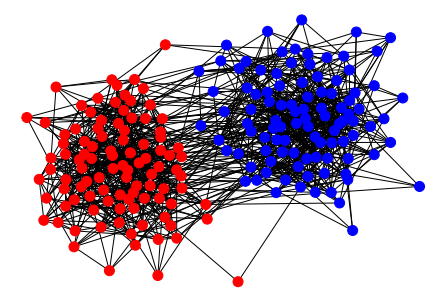

In [23]:
sn_net = snobbish_network(100, 0.1, 0.01)
nx.draw(sn_net, 
        node_color=nx.get_node_attributes(sn_net, 'color').values(), 
        node_size=100)

### Task 6. Watts-Strogatz model (0.75 point)

Implement Watts-Strogatz model (small-world model) — rewire an edge with probability `p` in a ring lattice with `n` nodes and `k` degree.

In [24]:
'''Do not touch the cell'''
def watts_strogatz_graph(n, k, p):
    G = ring_lattice(n, k)
    for node in G.nodes:
        rewire(G, node, k, p)
    return G

Write a function `ring_lattice` that returns a regular ring lattice with `n` nodes (0, 1, 2, ..., n-1) and `k` node degree.

In [25]:
def ring_lattice(n, k):
    # YOUR CODE HERE
    # raise NotImplementedError()
    G = nx.Graph()
    for i in range(1, k//2 + 1):
        for j in range(n):
            G.add_edge(j, (i + j) % n)
            G.add_edge(j, (j - i + n) % n)
    return G

In [26]:
assert nx.degree_histogram(ring_lattice(10, 2))[2] == 10
assert nx.degree_histogram(ring_lattice(10, 3))[2] == 10
assert nx.degree_histogram(ring_lattice(10, 4))[4] == 10

Write a function `rewire` that takes in input a ring lattice `G`, a `node`, a model parameter `k` and probability `p`. For every right hand side neighbor $i$, the function rewires an edge (`node`, $i$) into a random edge (`node`, $j$) with probability `p` where $i \neq j \neq $ `node`.

*Hints:*
* *Why do we only rewire right hand side edges? We want to guarantee that only untouched in previous iterations edges will be rewound. Look at the picture — we could not move the red edges in previous iterations.
![](https://raw.githubusercontent.com/netspractice/ml-on-graphs/main/assignment_generative_network_models/how_to_rewire.png)*
* *To speed up the generation, do not filter nodes to random selection. If a selected node produces an existing edge or a loop, just skip it.*

In [27]:
def rewire(G, node, k, p):
    # YOUR CODE HERE
    # raise NotImplementedError()
    
    for another_node in G.neighbors(node):
        if G.has_edge(node, another_node) and (p > random.random()) and ((node % (len(G.nodes) - 1) < another_node)):
            G.remove_edge(node, another_node)
            while True:
                yet_another_node = random.choice(list(G.nodes))
                if not G.has_edge(yet_another_node, node) and node != yet_another_node:
                    G.add_edge(node, yet_another_node)
                    break

In [28]:
cases = [[50, 8, 0.1], 
         [1000, 10, 0.01],
         [1000, 10, 0.5],
         [1000, 10, 0.99]]
for n, k, p in cases:
    G = watts_strogatz_graph(n, k, p)
    assert nx.number_of_nodes(G) == n
    assert nx.number_of_edges(G) == int(k / 2 * n)
    degree_seq = [degree for (node, degree) in G.degree]
    nxG = nx.watts_strogatz_graph(n, k, p, 1)
    nxdegree_seq = [degree for (node, degree) in nxG.degree]
    assert ks_2samp(degree_seq, nxdegree_seq).pvalue > 0.05

Let us draw a small-world graph in some steps of the algorithm

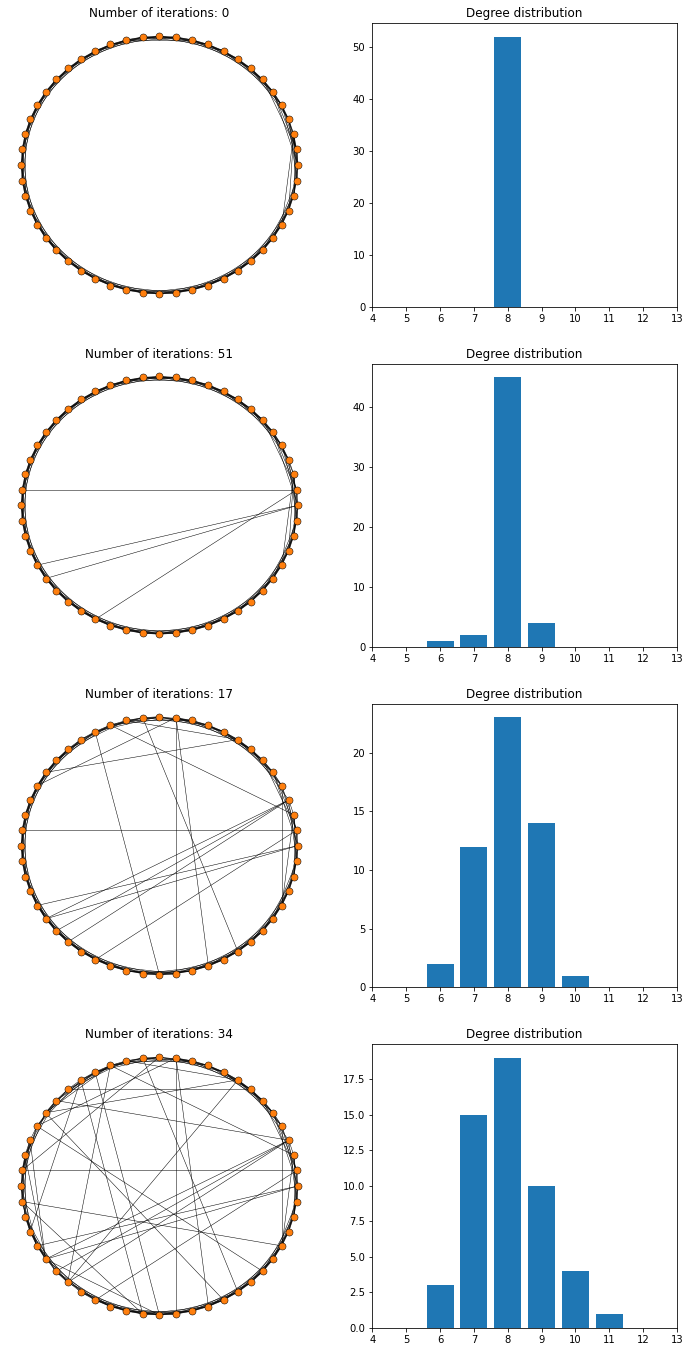

In [29]:
n, k, p = 52, 8, 0.2
G = ring_lattice(n, k)
plt.figure(figsize=(12, 6 * 4))
i = 1
for node in G.nodes:
    if node in np.arange(0, n+1, int(n/3)):
        plt.subplot(4, 2, i)
        plt.title('Number of iterations: {}'.format(node))
        nx.draw_circular(
            G,
            node_size=50, 
            width=0.5,
            linewidths=0.5,
            edgecolors='black',
            node_color='tab:orange')
        i += 1
        plt.subplot(4, 2, i)
        degree_seq = [degree for (node, degree) in G.degree]
        bins, freq = np.unique(degree_seq, return_counts=True)
        plt.bar(bins, freq)
        plt.xlim((4, 13))
        plt.title('Degree distribution')
        i += 1
    rewire(G, node, k, p)

### Task 7. Average path length in Watts-Strogatz (1.4 point)

Motivation of Small World model is to keep high clustering coefficients, achieving small path lengths. Let us check how clustering coefficients and path lengths change with respect to `p`.

Write a function `smallworld_path_len_clustering` with Watts-Strogatz model parameters `n, k` and np.array of `probabilities` that returns a tuple of two np.arrays: average path lengths and average clustering coefficient for each probability. The length of the array is the length of `probabilities`.

*Hints: 
* *to calculate the average shortest path length and average clustering coefficient, use `nx.average_shortest_path_length`, `nx.average_clustering`*
* *to speed up the generation, use `nx.watts_strogatz_graph`*

In [30]:
def smallworld_path_len_clustering(n, k, probabilities):
    # YOUR CODE HERE
    # raise NotImplementedError()
    
    lengths = []
    clustering = []
    for p in probabilities:  
        G = nx.watts_strogatz_graph(n, k, p, 1)
        lengths.append(nx.average_shortest_path_length(G))
        clustering.append(nx.average_clustering(G))
        
    return np.array(lengths), np.array(clustering)

In [31]:
n, k, probabilities = 100, 10, np.linspace(0.001, 0.999, 25)
lengths, clustering = smallworld_path_len_clustering(n, k, probabilities)
step_space = np.log(np.arange(1, len(lengths) + 1))
X = np.stack([step_space, np.ones(lengths.shape[0])], axis=1)
assert lengths.shape[0] == 25
assert 0.1 < -(np.linalg.pinv(X) @ np.log(lengths))[0] < 0.25
assert 0.65 < clustering[0] < 0.68
assert 0.07 < clustering[-1] < 0.11

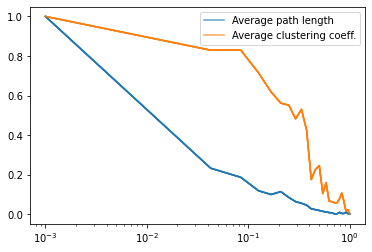

In [32]:
n, k, probabilities = 100, 5, np.linspace(0.001, 0.999, 25)
for _ in range(5):
    lengths, clustering = smallworld_path_len_clustering(n, k, probabilities)
    plt.plot(probabilities, minmax_scale(lengths, (0, 1)), 
             c='tab:blue', alpha=0.7)
    plt.plot(probabilities, minmax_scale(clustering, (0, 1)), 
             c='tab:orange', alpha=0.7)
plt.xscale('log')
plt.legend(['Average path length', 'Average clustering coeff.'])
plt.show()

### Task 8. Barabasi-Albert model (0.75 point)

Implement Barabasi-Albert model (preferential attachment model) – a growth process where each new node connects to `m` existing nodes. The higher node degree, the higher probability of the connection. The final number of nodes is `n`.

You start from a star graph with `m + 1` nodes. In each step you create `m` edges between a new node and existing nodes. The probability of connection to the node $i$ is 
$$p(i) = \frac{k_i}{\sum k}$$

Write a function `attach` that attaches a `node` to a graph `G` through `m` edges.

*Hint: Create a list with repeated nodes from a list of edges. For example, $[(1, 2), (2, 3), (2, 4)] \to [1, 2, 2, 3, 2, 4]$. Uniformly select nodes one-by-one. Apply `random.choice` instead of `np.random.choice` to speed up the generation.*

In [33]:
'''Do not touch the cell'''
def barabasi_albert_graph(n, m, random_seed=1):
    G = nx.star_graph(m)
    for i in range(1, n - m):
        attach(m + i, G, m)
    return G

In [34]:
def attach(node, G, m):
    # YOUR CODE HERE
    # raise NotImplementedError()
    
    bst = []
    for u, v in G.edges:                                      
        bst.append(u)
        bst.append(v)
    added_edges = 0
    while added_edges < m:
        v = random.choice(bst)
        if not G.has_edge(node, v):
            G.add_edge(node, v)
            added_edges += 1

In [35]:
G = nx.star_graph(3)
attach(4, G, 3)
assert nx.number_of_edges(G) == 6

cases = [[10, 3], 
         [1000, 3], 
         [1000, 20]]
for n, m in cases:
    G = barabasi_albert_graph(n, m)
    degree_seq = [degree for (node, degree) in G.degree]
    nxG = nx.barabasi_albert_graph(n, m)
    nxdegree_seq = [degree for (node, degree) in nxG.degree]
    assert ks_2samp(degree_seq, nxdegree_seq).pvalue > 0.05

Let us see what the growth process looks like

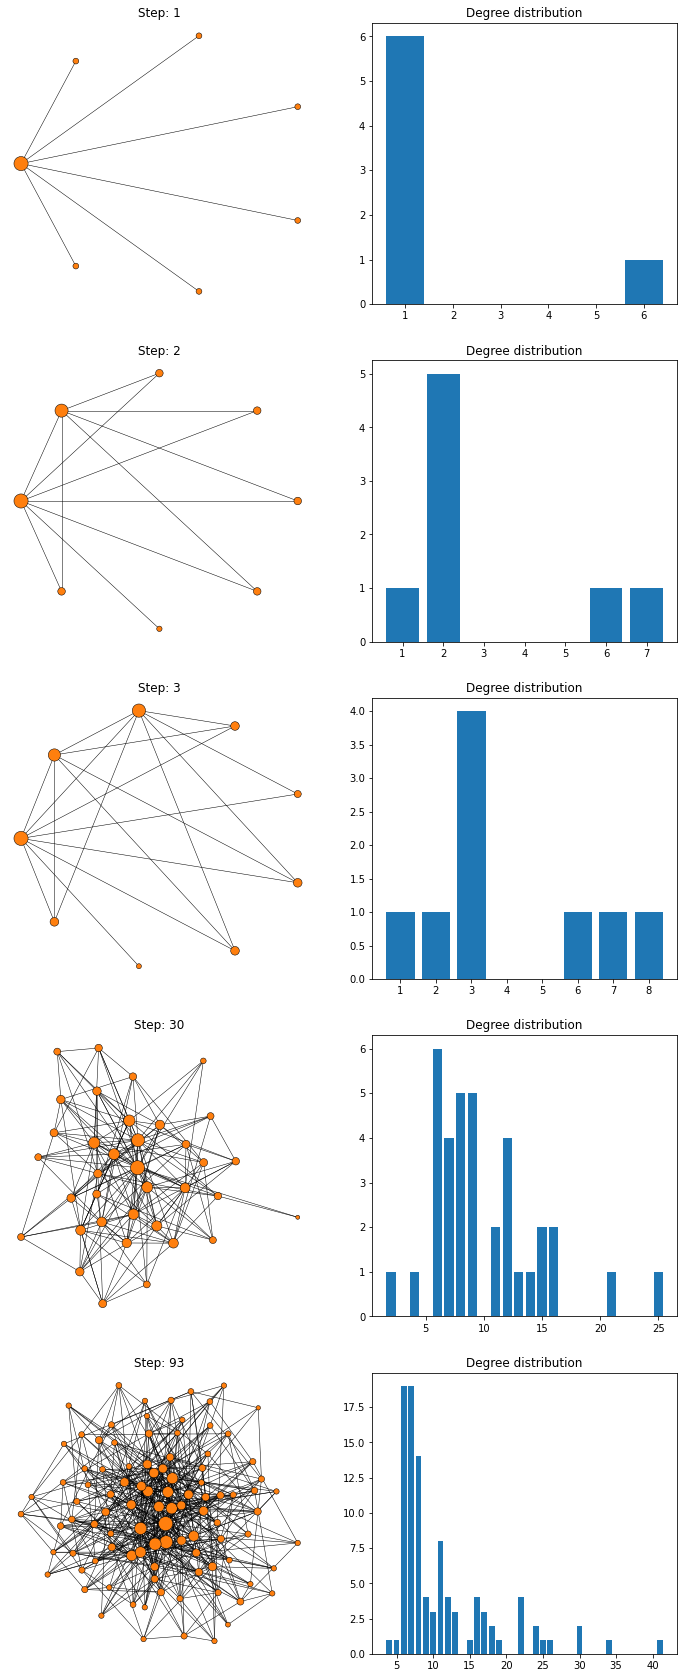

In [36]:
n, m = 100, 6
G = nx.star_graph(m)
plt.figure(figsize=(12, 6 * 5))
j = 1
for i in range(1, n - m):
    if i in [1, 2, 3, 30, n-m-1]:
        plt.subplot(5, 2, j)
        j += 1
        sizes = np.array(list(nx.degree_centrality(G).values()))
        sizes = sizes / max(sizes) * 200
        if i <= 3:
            pos = nx.layout.shell_layout(G)
        else:
            pos = nx.layout.spring_layout(G)
        nx.draw(
            G,
            pos=pos,
            with_labels=False, 
            node_size=sizes, 
            width=0.5,
            linewidths=0.5,
            edgecolors='black',
            node_color='tab:orange')
        plt.title('Step: {}'.format(i))
        degree_seq = [degree for (node, degree) in G.degree]
        bins, freq = np.unique(degree_seq, return_counts=True)
        plt.subplot(5, 2, j)
        j += 1
        plt.bar(bins, freq)
        plt.title('Degree distribution')
    attach(m + i, G, m)

### Task 9. Degree dynamics in Barabasi-Albert model (1.4 points)

Measure the degree dynamics in Barabasi-Albert model of one of the initial nodes and of the nodes added to the network at intermediate time moments (steps of the algorithm).

Write a function `generate_degree_dynamics` that takes np.array with considered nodes, generates Barabasi-Albert graph ($n=3000$, $m=6$) and returns a np.array of the shape `(29, len(nodes))` — degrees of these nodes at time moments 100, 200, 300, ..., 3000. If the node does not exist yet, pass `np.nan` value.

*Hint: use the `barabasi_albert_graph` function as a template*

In [73]:
def generate_degree_dynamics(cons_nodes):
    # YOUR CODE HERE
    # raise NotImplementedError()
    n = 3000
    m = 6
    
    result = []
    G = nx.star_graph(m)
    for i in range(1, n - m):
        attach(m + i, G, m)
        
        if i % 100 == 0:
            result1 = []
            for key in cons_nodes:
                try:
                    result1.append(G.degree[key])
                except:
                    result1.append(np.nan)
            result.append(result1)
        
    return np.array(result)

In [74]:
degree_dynamics = generate_degree_dynamics([0, 100, 700, 2000])
assert degree_dynamics.shape == (29, 4)
assert np.all(np.isnan(degree_dynamics[0]) == [False, False,  True,  True])
assert np.all(np.isnan(degree_dynamics[9]) == [False, False,  False,  True])
assert degree_dynamics[0, 0] < degree_dynamics[-1, 0]
assert degree_dynamics[0, 1] < degree_dynamics[-1, 1]
assert degree_dynamics[-1, 0] > degree_dynamics[-1, 3]

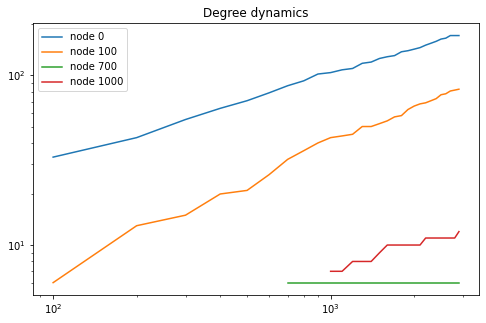

In [54]:
degree_dynamics = generate_degree_dynamics([0, 100, 700, 1000])
plt.figure(figsize=(8, 5))
time_space = np.tile(np.arange(100, 3000, 100), (4, 1)).T
plt.plot(time_space, degree_dynamics)
plt.legend(['node 0', 'node 100', 'node 700', 'node 1000'])
plt.title('Degree dynamics')
plt.xscale('log')
plt.yscale('log')
plt.show()